# Time-Domain Fitting with AMARES

While Fourier transforms and phase corrections are essential for visualizing spectra, quantitative Magnetic Resonance Spectroscopy (MRS) requires extracting exact metabolite concentrations. Time-domain fitting is the gold standard for this, especially for *in vivo* data where peaks strongly overlap or are distorted by baseline effects.

`xmris` integrates the powerful [pyAMARES](https://github.com/HawkMRS/pyAMARES) library to perform Advanced Method for Accurate, Robust and Efficient Spectral fitting (AMARES).

:::{dropdown} Why AMARES?

Here a section from the pyAMARES [paper](https://doi.org/10.3390/diagnostics14232668):

AMARES models the MRS signal as a sum of exponentially damped sinusoids. It uses parameters such as chemical shift, linewidth, amplitude, phase, and spectral lineshape, which can be constrained by prior knowledge. This knowledge includes initial parameters, parameter ranges, and relationships between different peaks and can be readily obtained from published literature. Peaks outside the region of interest can be filtered out, and parameters without prior knowledge can be fitted.

In contrast, frequency-domain fitting methods like LCModel require all metabolites to be modeled as basis set spectra. While this approach reduces the number of parameters to fit, it requires additional effort to obtain basis set spectra through experiments or numerical simulations. Moreover, frequency-domain fitting strategies typically require well-phased absorptive spectra. AMARES circumvents the sometimes subjective and complicated phasing procedure, making it particularly effective for analyzing data with distorted phases due to long receiver dead times.

LCModel and AMARES have been compared directly and proven to be comparable, each with its own advantages. However, AMARES is often the preferred method for quantifying X-nuclei MRS data, such as 13C and 31P MRS, where spectra typically exhibit fewer peaks and less J-coupling compared to 1H MRS. Also, AMARES can be used for post-processing, such as removing residuals from short-echo 1H MRS data measuring mobile macromolecules (MM). Recently, the introduction of pure-shift NMR techniques that simplify J-coupling split multiplets to singlets shows promise in facilitating AMARES fitting of 1H MRS.
:::

## The N-Dimensional Advantage

Traditional fitting tools often force you to write `for` loops to fit multiple spectra (like in an MRSI grid or a dynamic time-series). In `xmris`, the `.xmr.fit_amares()` accessor handles this for you. You pass in an N-dimensional `DataArray`, and the package automatically flattens the spatial dimensions, distributes the fitting across your CPU cores, and reconstructs the results into an aligned `xarray.Dataset`.

Let's create a synthetic MRSI dataset (multiple voxels) and quantify it in one line of code.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Ensure xmris accessors are registered
import xmris.accessor

## 1. Define Prior Knowledge
AMARES requires Prior Knowledge (PK) to know how many peaks to look for and what constraints to place on their parameters (amplitude, frequency, linewidth, phase). This is provided as a CSV file.

Let's write a simple 2-peak prior knowledge file to disk. We will model Phosphocreatine (PCr) at 0 ppm and an ATP peak at -7.5 ppm.

In [2]:
pk_csv_content = """Index,PCr,ATP
Initial Values,,
amplitude,10.0,5.0
chemicalshift,0.0,-7.5
linewidth,15.0,20.0
phase,0,0
g,0,0
Bounds,,
amplitude,"(0, ","(0, "
chemicalshift,"(-0.5, 0.5)","(-8.0, -7.0)"
linewidth,"(5.0, 30.0)","(10.0, 40.0)"
phase,"(-180, 180)","(-180, 180)"
g,"(0, 1)","(0, 1)"
"""

pk_path = Path("example_pk.csv")
pk_path.write_text(pk_csv_content)

278

## 2. Generate N-Dimensional Synthetic Data
We will simulate a 1D spatial array containing 5 voxels. To make it realistic, we will vary the amplitude of the PCr peak across the voxels, representing a spatial concentration gradient, while keeping ATP constant.

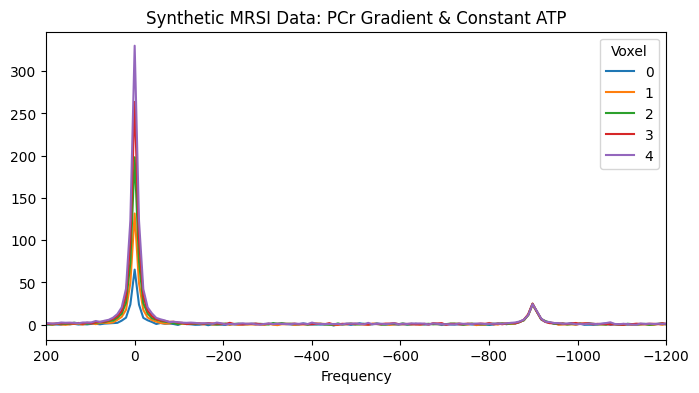

In [3]:
n_voxels = 5
n_points = 1024
sw = 10000.0  # Hz
mhz = 120.0  # 7T 31P
dt = 1.0 / sw
time = np.arange(n_points) * dt

# Pre-allocate the 2D array (Voxel x Time)
data = np.zeros((n_voxels, n_points), dtype=complex)

# True parameters (decay rate dk = linewidth * pi)
pcr_freq = 0.0 * mhz
atp_freq = -7.5 * mhz
decay_pcr = 15.0 * np.pi
decay_atp = 20.0 * np.pi

for v in range(n_voxels):
    # PCr amplitude increases across voxels (10 to 50)
    amp_pcr = 10.0 * (v + 1)
    # ATP amplitude is constant (5.0)
    amp_atp = 5.0

    # Generate pure FIDs
    fid_pcr = (
        amp_pcr * np.exp(-decay_pcr * time) * np.exp(1j * 2 * np.pi * pcr_freq * time)
    )
    fid_atp = (
        amp_atp * np.exp(-decay_atp * time) * np.exp(1j * 2 * np.pi * atp_freq * time)
    )

    # Combine and add noise
    signal = fid_pcr + fid_atp
    noise = np.random.normal(0, 0.5, n_points) + 1j * np.random.normal(0, 0.5, n_points)
    data[v, :] = signal + noise

# Package into an xarray DataArray
da_mrsi = xr.DataArray(
    data,
    dims=["Voxel", "Time"],
    coords={"Voxel": np.arange(n_voxels), "Time": time},
    attrs={"MHz": mhz, "sw": sw},
)

# Plot the generated spectra
spectra = da_mrsi.xmr.to_spectrum()

fig, ax = plt.subplots(figsize=(8, 4))
spectra.real.plot.line(x="Frequency", hue="Voxel", ax=ax, add_legend=True)
ax.set_xlim(200, -1200)  # Zoom into the peaks
ax.set_title("Synthetic MRSI Data: PCr Gradient & Constant ATP")
plt.show()

## 3. Fit the Data with xmris
We pass the `DataArray` to `.xmr.fit_amares()`.

Under the hood, `xmris` evaluates the Signal-to-Noise Ratio (SNR) of all 5 voxels, picks the one with the highest SNR to safely initialize the `pyAMARES` template, and then parallelizes the fitting across your CPU cores.

In [ ]:
# We use num_workers=4 to parallelize the fitting across our spatial dimensions!
ds_fit = da_mrsi.xmr.fit_amares(
    prior_knowledge_file=pk_path, method="least_squares", num_workers=4
)

Auto-selected FID index 4 for initialization(SNR: 66.99)
[AMARES | INFO] Checking comment lines in the prior knowledge file
[AMARES | WARNING] There is no styled_df!
[AMARES | WARNING] There is no simple_df!


ValueError: max_workers must be greater than 0

In [ ]:
# Hidden cell for pytest-cov tracking, has to be a single thread with one worker only!
ds_fit = da_mrsi.xmr.fit_amares(
    prior_knowledge_file=pk_path, method="least_squares", num_workers=1
)

### Exploring the Resulting Dataset

The returned `Dataset` is incredibly powerful. Instead of returning raw numbers, `xmris` neatly categorizes the fitting outputs into two sets of variables, mapped along their natural physical dimensions:

1. **Time-Domain Signals (`Voxel`, `Time`)**: The arrays `raw_data`, `fit_data`, and `residuals`.
2. **Quantified Parameters (`Voxel`, `Metabolite`)**: The tabular values such as `amplitude`, `chem_shift`, `linewidth`, `phase`, `crlb`, and `snr`.

:::{dropdown} Deep Dive: DataArray vs. Dataset
In the `xarray` ecosystem:
* **`DataArray`**: A single, N-dimensional array with labeled dimensions and coordinates (like a single physical quantity).
* **`Dataset`**: A dictionary-like container of multiple aligned `DataArray` objects that share dimensions.

Because fitting yields both continuous time-domain signals (mapped to `Time`) and discrete quantified parameters (mapped to a new `Metabolite` dimension), we use a `Dataset` to hold everything perfectly aligned in one neat package!

[Here](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataset) the official documentation from xarray.
:::

Because it maps the results to the newly created `Metabolite` dimension, you can easily query and plot quantitative maps without touching a Pandas DataFrame or slicing NumPy arrays. Let's verify our spatial concentration gradient by plotting the fitted amplitudes across the voxels.

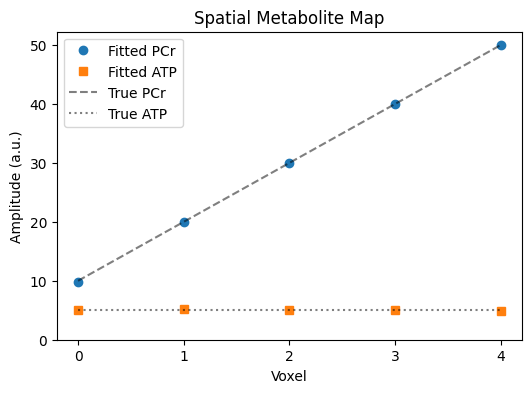

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

# Because everything is aligned, plotting parameter maps is trivial
ds_fit.amplitude.sel(Metabolite="PCr").plot(
    ax=ax, marker="o", linestyle="none", label="Fitted PCr"
)
ds_fit.amplitude.sel(Metabolite="ATP").plot(
    ax=ax, marker="s", linestyle="none", label="Fitted ATP"
)

# Plot the ground truth for comparison
ax.plot(
    np.arange(n_voxels),
    [10 * (v + 1) for v in range(n_voxels)],
    "k--",
    alpha=0.5,
    label="True PCr",
)
ax.plot(
    np.arange(n_voxels),
    [5.0 for _ in range(n_voxels)],
    "k:",
    alpha=0.5,
    label="True ATP",
)

ax.set_ylim(bottom=0)  # Start y-axis at 0
ax.set_xticks(np.arange(n_voxels))  # Integer labels for voxels

ax.set_title("Spatial Metabolite Map")
ax.set_ylabel("Amplitude (a.u.)")
ax.legend()
plt.show()

### Quality Control (Visualizing the Fit)
The `Dataset` also contains the mathematically reconstructed `fit_data` and the `residuals` in the time domain. Using the `.xmr.to_spectrum()` accessor, we can instantly visualize the fit quality for a specific voxel in the frequency domain.

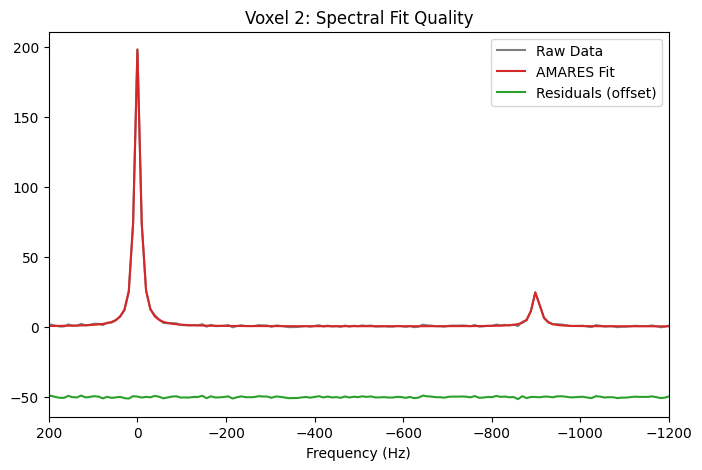

In [ ]:
# Select the center voxel
voxel_ds = ds_fit.isel(Voxel=2)

# Convert Time-domain arrays to Frequency-domain spectra
spec_raw = voxel_ds.raw_data.xmr.to_spectrum()
spec_fit = voxel_ds.fit_data.xmr.to_spectrum()
spec_res = voxel_ds.residuals.xmr.to_spectrum()

fig, ax = plt.subplots(figsize=(8, 5))

# Plot Real parts
ax.plot(
    spec_raw.coords["Frequency"],
    spec_raw.real,
    color="black",
    alpha=0.5,
    label="Raw Data",
)
ax.plot(
    spec_fit.coords["Frequency"], spec_fit.real, color="tab:red", label="AMARES Fit"
)
ax.plot(
    spec_res.coords["Frequency"],
    spec_res.real - 50,
    color="tab:green",
    label="Residuals (offset)",
)

ax.set_xlim(200, -1200)  # Zoom into the peaks
ax.set_title("Voxel 2: Spectral Fit Quality")
ax.set_xlabel("Frequency (Hz)")
ax.legend()
plt.show()

In [ ]:
# CRITICAL ASSERTIONS FOR NBMAKE CI
# 1. Check Dataset generation and dimensions
assert isinstance(ds_fit, xr.Dataset), "Output must be an xarray Dataset"
assert "amplitude" in ds_fit.data_vars
assert "raw_data" in ds_fit.data_vars
assert "fit_data" in ds_fit.data_vars
assert "residuals" in ds_fit.data_vars

# 2. Check Dimensional Alignment
assert ds_fit.amplitude.dims == ("Voxel", "Metabolite"), (
    "Amplitude map dimensions are incorrect"
)
assert ds_fit.fit_data.dims == ("Voxel", "Time"), (
    "Reconstructed fit dimensions are incorrect"
)
assert len(ds_fit.coords["Metabolite"]) == 2, (
    "Should have found 2 metabolites (PCr, ATP)"
)

# 3. Check Fit Accuracy (Quantitative)
fitted_pcr_amps = ds_fit.amplitude.sel(Metabolite="PCr").values
true_pcr_amps = np.array([10.0, 20.0, 30.0, 40.0, 50.0])
# Ensure the fit recovered the gradient correctly within a 5% error margin (allowing for noise)
np.testing.assert_allclose(
    fitted_pcr_amps,
    true_pcr_amps,
    rtol=0.05,
    err_msg="PCr amplitudes were not fitted correctly",
)

fitted_atp_amps = ds_fit.amplitude.sel(Metabolite="ATP").values
true_atp_amps = np.array([5.0, 5.0, 5.0, 5.0, 5.0])
np.testing.assert_allclose(
    fitted_atp_amps,
    true_atp_amps,
    rtol=0.1,
    err_msg="ATP amplitudes were not fitted correctly",
)

# 4. Check that residuals are actually noise (Mean should be close to 0)
voxel_residual = ds_fit.residuals.isel(Voxel=2).values
assert abs(np.mean(voxel_residual)) < 1.0, (
    "Residuals are suspiciously high, indicating a bad fit"
)

# 5. Cleanup dummy file
pk_path.unlink(missing_ok=True)